## 1.Setup Basic Parameters

In [1]:
import numpy as np

# Parameters
Tmax = 60
D = 6  # Number of locations
L = 1  # Number of locations connected to the outside world
n = np.array([0, 2000, 3000, 1200, 1500, 3200])  # Population at each location

## 2. Create Connectivity Matrix W

In [2]:
def create_connectivity_matrix(D, L):
    W = np.zeros((D, D), dtype=int)
    
    # Populate W with random values and ensure symmetry
    for i in range(1, D):
        for j in range(i+1, D):
            W[i, j] = np.random.randint(0, 100)  # Adjust range as needed
            W[j, i] = W[i, j]

    # Set the connections from the outside world
    for i in range(1, L+1):
        W[0, i] = W[i, 0] = np.random.randint(1, 100)  # Ensure these are non-zero

    # Zero out the diagonal
    np.fill_diagonal(W, 0)
    return W

W = create_connectivity_matrix(D, L)

In [3]:
import pandas as pd

W = create_connectivity_matrix(D, L)

# Convert the matrix to a DataFrame for better visualization
W_df = pd.DataFrame(W, columns=[f"Location {i+1}" for i in range(D)], index=[f"Location {i+1}" for i in range(D)])
W_df

,Location 1,Location 2,Location 3,Location 4,Location 5,Location 6
Location 1,0,19,0,0,0,0
Location 2,19,0,13,91,70,4
Location 3,0,13,0,68,83,76
Location 4,0,91,68,0,22,58
Location 5,0,70,83,22,0,95
Location 6,0,4,76,58,95,0


## 3.Initialize State Vectors

In [4]:
# Initialize state vectors
x = np.zeros((D, 4), dtype=float)  # Use float type for the state vectors

for i in range(D):
    if n[i] == 0:
        x[i] = np.zeros(4)  # Explicitly set to zero for locations with zero population
    else:
        # Directly assign the percentages
        percentages = np.array([0.80, 0.05, 0.05, 0.10])  # Susceptible, Exposed, Infected, Recovered
        x[i] = percentages * n[i]  # Scale by population
        x[i] = np.round(x[i]).astype(int)  # Round to integer

In [5]:
# Convert the state vectors to a DataFrame for better visualization
state_vectors_df = pd.DataFrame(x, columns=['Susceptible', 'Exposed', 'Infected', 'Recovered'], 
                                index=[f"Location {i+1}" for i in range(D)])
state_vectors_df

,Susceptible,Exposed,Infected,Recovered
Location 1,0.0,0.0,0.0,0.0
Location 2,1600.0,100.0,100.0,200.0
Location 3,2400.0,150.0,150.0,300.0
Location 4,960.0,60.0,60.0,120.0
Location 5,1200.0,75.0,75.0,150.0
Location 6,2560.0,160.0,160.0,320.0


## 4. Implement the Migration Logic

In [6]:
def balanced_migration_step(W, x):
    D = W.shape[0]
    Delta_out = np.zeros_like(x, dtype=float)  # Use float type
    Delta_in = np.zeros_like(x, dtype=float)   # Use float type

    # Calculating how many individuals will leave each location
    for i in range(D):
        for j in range(D):
            if i != j and W[i, j] > 0:
                for cat in range(4):
                    proportion = x[i, cat] / x[i].sum() if x[i].sum() > 0 else 0
                    Delta_out[i, cat] += W[i, j] * proportion

    # Ensuring the total number of people leaving a location equals those arriving
    for i in range(D):
        for j in range(D):
            if i != j and W[i, j] > 0:
                Delta_in[j] += Delta_out[i] * W[i, j] / W[i].sum() if W[i].sum() > 0 else 0

    # Adjust the population in each location
    x_new = x - np.round(Delta_out).astype(int) + np.round(Delta_in).astype(int)

    return x_new

In [7]:
x_new = balanced_migration_step(W, x)

In [8]:
x_new

array([[1.500e+01, 1.000e+00, 1.000e+00, 2.000e+00],
       [1.584e+03, 9.900e+01, 9.900e+01, 1.980e+02],
       [2.400e+03, 1.500e+02, 1.500e+02, 3.000e+02],
       [9.600e+02, 6.000e+01, 6.000e+01, 1.200e+02],
       [1.200e+03, 7.500e+01, 7.500e+01, 1.500e+02],
       [2.560e+03, 1.600e+02, 1.600e+02, 3.200e+02]])

## 5. Implement Infection Dynamics

In [9]:
def infection_step(x):
    α = 0.60  # Transmission rate
    β = 0.20  # Recovery rate
    γ = 0.30  # Progression rate from exposed to infectious
    D = x.shape[0]
    x_updated = np.zeros_like(x)
    for i in range(D):
        n = x[i, :].sum()
        if n > 0:
            S, E, I, R = x[i, 0], x[i, 1], x[i, 2], x[i, 3]
            δ_SE = np.random.binomial(S, α*I/n if n > 0 else 0)
            δ_EI = np.random.binomial(E, γ)
            δ_IR = np.random.binomial(I, β)
            x_updated[i] = [S - δ_SE, E + δ_SE - δ_EI, I + δ_EI - δ_IR, R + δ_IR]
    return x_updated

## 6. Run the Simulation

In [10]:
# Initialize history array to store state of each location on each day
history = np.zeros((Tmax, D, 4), dtype=int)

# Run the simulation
for t in range(Tmax):
    # Migration step
    x = balanced_migration_step(W, x)
     # Infection step
    x = infection_step(x)

    # Record the state for the day
    history[t] = x

# Convert history to a DataFrame for better visualization (optional)
# This step creates a DataFrame showing the state of each location on each day
history_df = pd.DataFrame(history.reshape(Tmax * D, 4), 
                          columns=['Susceptible', 'Exposed', 'Infected', 'Recovered'],
                          index=[f"Day {t // D + 1}, Location {t % D + 1}" for t in range(Tmax * D)])


In [11]:
history_df

,Susceptible,Exposed,Infected,Recovered
"Day 1, Location 1",14,2,1,2
"Day 1, Location 2",1528,119,122,211
"Day 1, Location 3",2322,178,171,329
"Day 1, Location 4",936,67,65,132
"Day 1, Location 5",1171,78,83,168
...,...,...,...,...
"Day 60, Location 2",116,0,1,1856
"Day 60, Location 3",179,1,6,2822
"Day 60, Location 4",69,0,1,1119
"Day 60, Location 5",88,0,1,1406


In [12]:
x

array([[1.000e+00, 0.000e+00, 0.000e+00, 1.200e+01],
       [1.160e+02, 0.000e+00, 1.000e+00, 1.856e+03],
       [1.790e+02, 1.000e+00, 6.000e+00, 2.822e+03],
       [6.900e+01, 0.000e+00, 1.000e+00, 1.119e+03],
       [8.800e+01, 0.000e+00, 1.000e+00, 1.406e+03],
       [1.900e+02, 1.000e+00, 3.000e+00, 3.010e+03]])

In [13]:
history

array([[[  14,    2,    1,    2],
        [1528,  119,  122,  211],
        [2322,  178,  171,  329],
        [ 936,   67,   65,  132],
        [1171,   78,   83,  168],
        [2483,  188,  187,  342]],

       [[  15,    1,    0,    3],
        [1469,  138,  131,  243],
        [2233,  219,  183,  365],
        [ 892,   96,   73,  140],
        [1130,   91,   98,  181],
        [2388,  216,  215,  380]],

       [[  14,    1,    1,    2],
        [1404,  168,  139,  270],
        [2152,  228,  224,  396],
        [ 862,   93,   86,  160],
        [1080,  112,  107,  201],
        [2294,  245,  227,  432]],

       ...,

       [[   1,    0,    0,   12],
        [ 116,    0,    1, 1856],
        [ 180,    1,    6, 2819],
        [  69,    1,    1, 1118],
        [  88,    0,    2, 1405],
        [ 191,    0,    5, 3008]],

       [[   1,    0,    0,   12],
        [ 116,    0,    1, 1856],
        [ 179,    2,    6, 2820],
        [  69,    0,    2, 1118],
        [  88,    0,    1, 

## 7. Plot

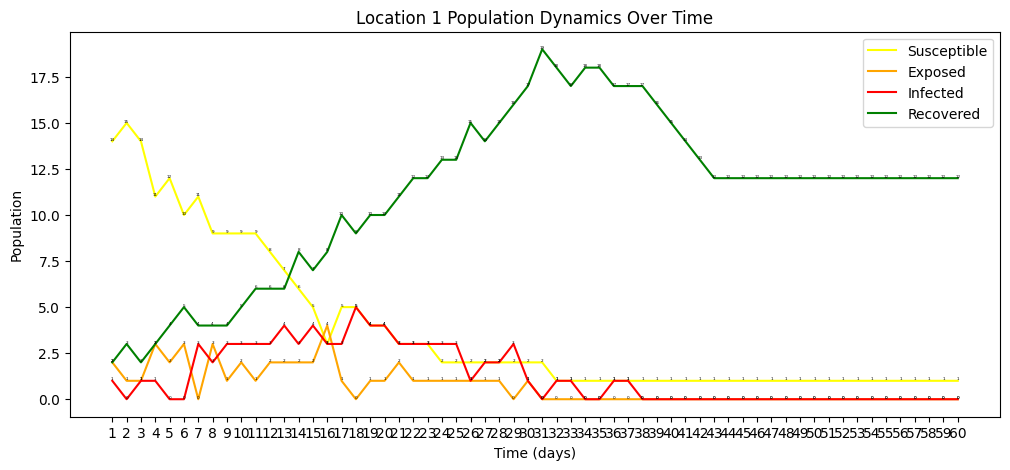

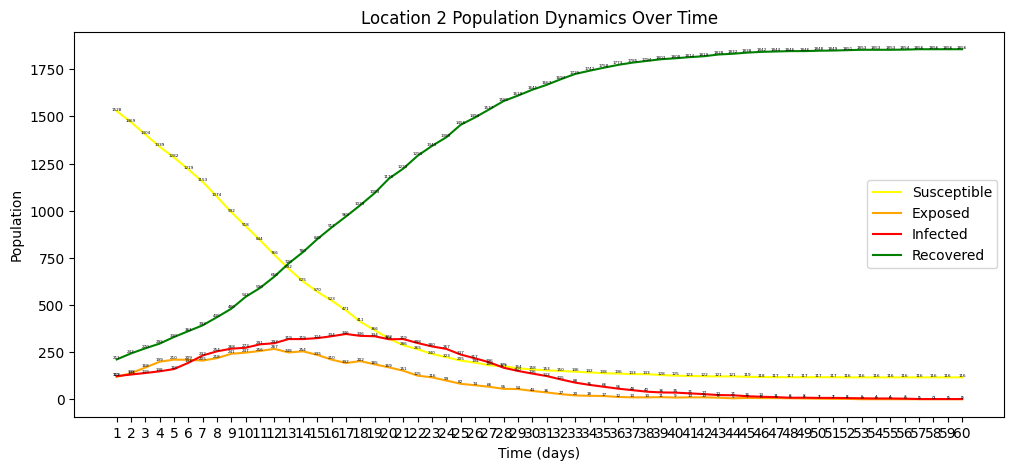

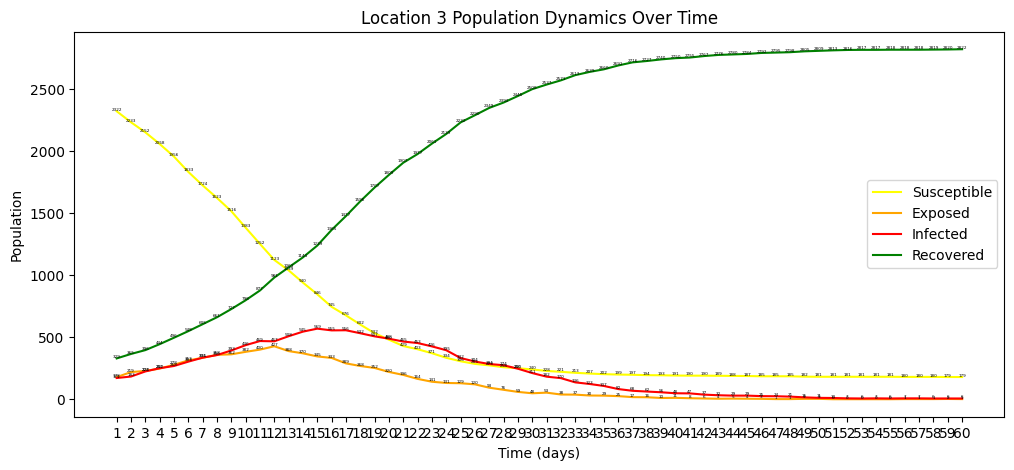

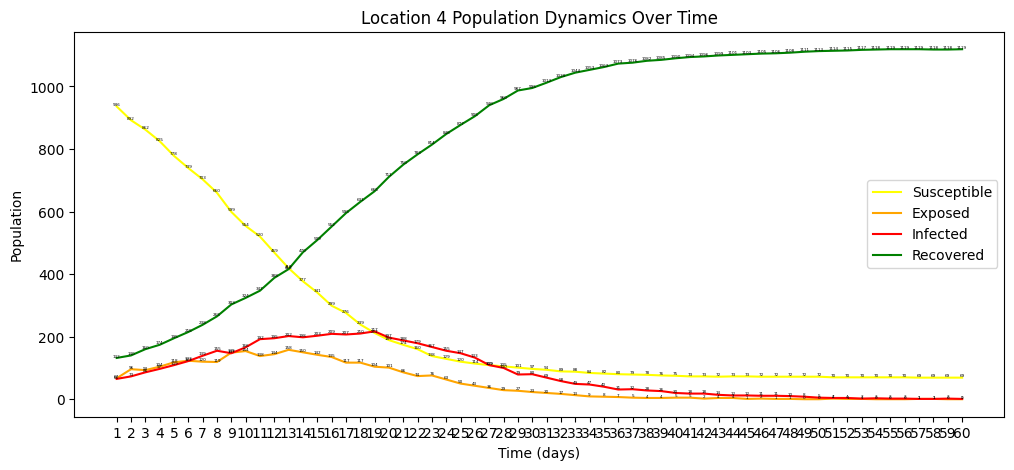

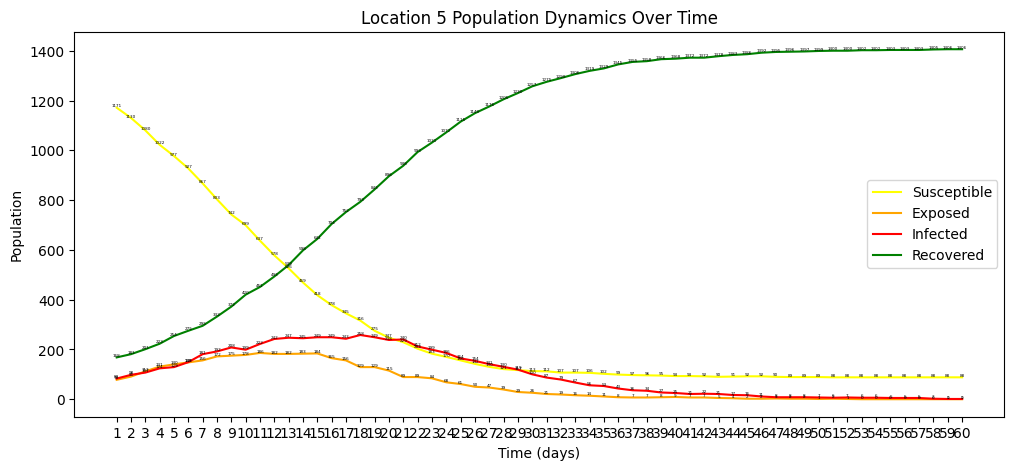

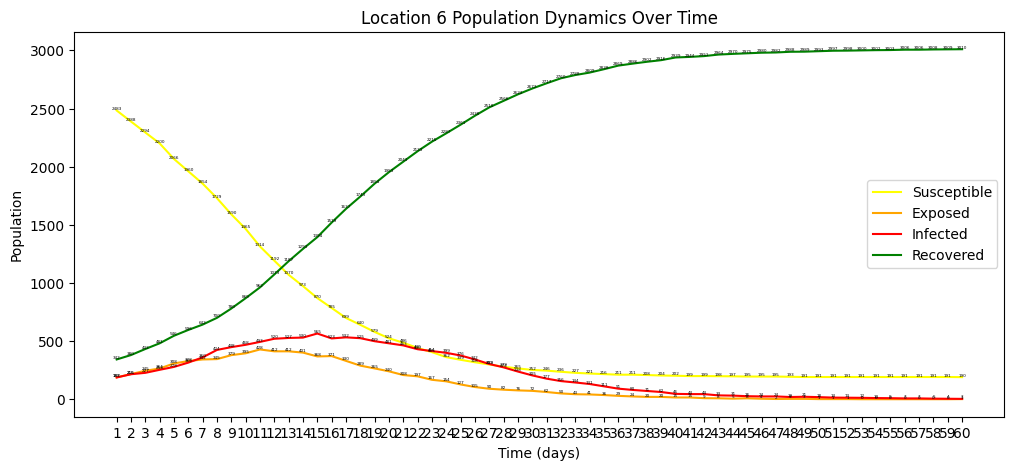

In [14]:
import matplotlib.pyplot as plt

# Plotting the results for each location through time
compartment_labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered']
compartment_colors = ['yellow', 'orange', 'red', 'green']

# Creating a separate plot for each location
for i in range(D):
    plt.figure(figsize=(12, 5))
    for j in range(4):
        # Extracting the specific compartment data for each location
        compartment_data = history[:, i, j]
        days = np.arange(len(compartment_data))  # No offset here, Python uses zero-based indexing
        plt.plot(days, compartment_data, label=compartment_labels[j], color=compartment_colors[j])

        # Adding labels to each point
        for day, value in enumerate(compartment_data):
            plt.text(day, value, f'{int(value)}', fontsize=3, ha='center', va='bottom')

     # Set x-axis to show days starting from 1, aligning them with the data points
    max_days = len(history[:, i, 0])
    plt.xticks(ticks=np.arange(max_days), labels=np.arange(1, max_days + 1))


    plt.title(f"Location {i+1} Population Dynamics Over Time")
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.legend()
    plt.grid(False)
    plt.show()
